In [131]:
import numpy as np 
import os, json
from os.path import isdir, join
from functools import cmp_to_key
import itertools

In [114]:
class score:
    def __init__(self):
        pass
    def get_course_score(self, courseInfo):
        return 0
    def get_schedule_score(self, scheduleInfo):
        return 0 
    def get_compact_score (self, scheduleInfo):
        return 0

In [115]:
mock = [
{# 201 Lec
    'name': 'CSCI201',
    'must have': True,
    'prefer':False,
    'unit': 4,
    'session':
    [
        {'ID': '30303', 'type':'Lec','time':'08:00am-09:20am, TTh', 'instructor':'Miller, Jeffrey', 'isFull':False ,'must have':False, 'prefer':True},
        {'ID': '30254', 'type':'Lec','time':'11:00am-12:20pm, TTh', 'instructor':'Grujic, Olivera', 'isFull':False,'must have':False, 'prefer':False},
        {'ID': '29998', 'type':'Lec','time':'12:30pm-01:50pm, TTh', 'instructor':'Grujic, Olivera', 'isFull':False,'must have':False, 'prefer':False},
        {'ID': '29979', 'type':'Lec','time':'02:00pm-03:20pm, MW' , 'instructor':'Grujic, Olivera', 'isFull':False ,'must have':False, 'prefer':False},
        {'ID': '29993', 'type':'Lec','time':'10:00am-11:50am, MW' , 'instructor':'Grujic, Olivera', 'isFull':False,'must have':False, 'prefer':False},
        # 201 discussion
        {'ID': '30239', 'type':'Lab','time':'10:00am-11:50am, W', 'instructor':'', 'isFull':False,'must have':False, 'prefer':False},
        {'ID': '30238', 'type':'Lab','time':'12:00pm-01:50pm, W', 'instructor':'', 'isFull':False,'must have':False, 'prefer':False},
        {'ID': '30237', 'type':'Lab','time':'02:00pm-03:50pm, T', 'instructor':'', 'isFull':False,'must have':False, 'prefer':False},
        {'ID': '30134', 'type':'Lab','time':'04:00pm-05:50pm, T', 'instructor':'', 'isFull':True,'must have':False, 'prefer':False},
        {'ID': '30385', 'type':'Lab','time':'04:00pm-05:50pm, T', 'instructor':'', 'isFull':True,'must have':True, 'prefer':False},
        {'ID': '30241', 'type':'Lab','time':'06:00pm-07:50pm, T', 'instructor':'', 'isFull':False,'must have':False, 'prefer':False},
        {'ID': '30396', 'type':'Lab','time':'06:00pm-07:50pm, T', 'instructor':'', 'isFull':False,'must have':False, 'prefer':False},
        {'ID': '29904', 'type':'Lab','time':'06:00pm-07:50pm, W', 'instructor':'', 'isFull':True,'must have':False, 'prefer':True},
        # 201 quiz
        {'ID': '30028', 'type':'Quiz', 'time':'', 'instructor':'', 'isFull':False,'must have':False, 'prefer':False}
    ]
},
# 356 Lec 
{
    'name': 'CSCI356',
    'must have': True,
    'prefer':False,
    'unit':4,
    'session': 
    [
        {'ID': '29962', 'type':'Lec','time':'02:00pm-03:20pm, TTh', 'instructor':'Paolieri, Marco', 'isFull':False ,'must have':False, 'prefer':False},
        {'ID': '29912', 'type':'Lec','time':'09:30am-10:50am, TTh', 'instructor':'Goodney, Andrew', 'isFull':True ,'must have':False, 'prefer':True},
        # 356 Discussino 
        {'ID': '30239', 'type':'Dis','time':'02:00pm-03:50pm, F', 'instructor':'', 'isFull':False,'must have':False, 'prefer':False},
        {'ID': '30124', 'type':'Dis','time':'10:00am-11:50am, F', 'instructor':'', 'isFull':False,'must have':False, 'prefer':False},
        {'ID': '30239', 'type':'Dis','time':'12:00pm-01:50pm, F', 'instructor':'', 'isFull':False,'must have':False, 'prefer':False},
        # 356 Quiz 
        {'ID': '30285', 'type':'Quiz', 'time':'08:00pm-09:50pm, T', 'instructor':'', 'isFull':False,'must have':False, 'prefer':False}
    ]
},
# 467 Lec
    
{
    'name':'CSCI467',
    'must have': True,
    'prefer': False,
    'unit':4,
    'session': 
    [
        {'ID': '30277', 'type':'Lec','time':'02:00pm-03:20pm, MW', 'instructor':'Rajati, Mohammad Reza', 'isFull':False ,'must have':False, 'prefer':False},
        # 467 Dis
        { 'ID': '30278', 'type':'Dis','time':'04:00pm-05:50pm, M', 'instructor':'', 'isFull':False ,'must have':False, 'prefer':True},
        { 'ID': '30279', 'type':'Dis','time':'04:00pm-05:50pm, T', 'instructor':'', 'isFull':False ,'must have':True, 'prefer':False}
    ]
},
# ENGR100
{
    'name':'ENGR100',
    'must have': False,
    'prefer': False,
    'unit':1,
    'session':
    [
        { 'ID': '28501', 'type':'Lec','time':'01:00pm-01:50pm, F', 'instructor':'', 'isFull':False ,'must have':False, 'prefer':False}
    ]
},
    
# REL137
{
    'name':'REL137',
    'must have': False,
    'prefer': True,
    'unit':4,
    'session':
    [
        {'ID':'60042', 'type':'Lec','time':'11:00am-12:20pm, TTH', 'instructor':'Jackson, Sherman', 'isFull': False, 'must have':False, 'prefer': False},
        {'ID':'60043', 'type':'Dis','time':'10:00am-10:50am, W', 'instructor':'Qazwini, Hadi', 'isFull': False, 'must have':False, 'prefer': False}
    ]
}
]

In [107]:
from datetime import datetime
from collections import Counter
class greedySearch:
    def __init__(self, path):
        with open (join(path, 'profScoreDB.json')) as handle:
            self.profScore = json.load(handle) # read in prof score file 
        
    def get_top_k(self, courseList, constrains=[]):
        courseList = self.__process_data(courseList, constrains) #
        
    
    def __process_data(self, courseList, constrains):
        for course in  courseList:
            self.__time_encoder(course) #  encode session time into array index 
        courseList = sorted(courseList, key = cmp_to_key(self.__cmp)) #  re-arrange the course list in priority order
        for course in  courseList:
            course['session'] = sorted(course['session'], key = cmp_to_key(self.__cmp)) # re-arrange session lists in priority order
            tempDict ={'Lec':[], 'Lab':[], 'Dis':[], 'Quiz':[]}
            for session in course['session']:
                tempDict[session['type']].append(session)
            course['grouped'] = tempDict
        return courseList
        
    '''
    encode textual time into array index, which later is used to check conflicts 
    '''
    def __time_encoder(self, course):
        for session in course['session']: 
            if session['time'] == '':
                session['timeNumeric'] = ()
                continue
            parsed = session['time'].split(',') # get time, day of week
            days = Counter(list(parsed[1]))
            daysNumeric = [] # convert day to numbers 
            if 'M' in days:
                daysNumeric.append(0)
            if 'T' in days and ('h' not in days or days['T']>days['h']):
                daysNumeric.append(1)
            if 'W' in days:
                daysNumeric.append(2)
            if 'T' in days and 'h' in days:
                daysNumeric.append(3)
            if 'F' in days:
                daysNumeric.append (4)

            time = parsed[0].split('-') # get start, end time
            startNumeric = [int(time[0].split(':')[0]), int(time[0].split(':')[1][:2])]
            endNumeric = [int(time[1].split(':')[0]), int(time[1].split(':')[1][:2])]
            if 'pm' in time[0] and '12' not in time[0]:
                startNumeric[0] +=12
            if 'pm' in time[1] and '12' not in time[1]:
                endNumeric[0] +=12
            startNumeric = int ((startNumeric[0]-7)*6 + (startNumeric[1]/10))# convert to index
            endNumeric = int ((endNumeric[0]-7)*6 + (endNumeric[1]/10)) # convert to index
            timeNumeric = []
            for i in daysNumeric:
                timeNumeric.append(((i*96) + startNumeric, (i*96) + endNumeric))
            session['timeNumeric'] = timeNumeric
    '''
    comparison logic: must have has the ultimate priority regardless of registration status (close)
    then isFull has the secondary priority. If a session is full, it is considered last
    then prefer has the third priority. If a session is preferred but not full, it will be place behind must-have but 
    before not preferred or closed session
    '''
    def __cmp(self, a,b):
        if a['must have'] :
            return -1 # a>b
        elif b['must have'] :
            return 1# b>a
        try:
            if a['isFull']:
                return 1
            if b['isFull']:
                return -1
        except:
            pass
        
        if a['prefer'] and not b['prefer']:
            return -1
        elif b['prefer'] and not a['prefer']:
            return 1
        else:
            return 0 # same priority

In [108]:
model = greedySearch('./')

In [116]:
%%timeit
sortedL = model.get_top_k(mock)

157 µs ± 1.7 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [118]:
for course in sortedL:
    print ('COURSE:', course['name'], ', must have:', course['must have'], ', prefer:', course['prefer'])
    for session in course['session']:
        print ('\t\tmust have:', session['must have'], ', prefer:', session['prefer'], ', isFull:', session['isFull'])

COURSE: CSCI467 , must have: True , prefer: False
		must have: True , prefer: False , isFull: False
		must have: False , prefer: True , isFull: False
		must have: False , prefer: False , isFull: False
COURSE: CSCI356 , must have: True , prefer: False
		must have: False , prefer: False , isFull: False
		must have: False , prefer: False , isFull: False
		must have: False , prefer: False , isFull: False
		must have: False , prefer: False , isFull: False
		must have: False , prefer: False , isFull: False
		must have: False , prefer: True , isFull: True
COURSE: CSCI201 , must have: True , prefer: False
		must have: True , prefer: False , isFull: True
		must have: False , prefer: True , isFull: False
		must have: False , prefer: False , isFull: False
		must have: False , prefer: False , isFull: False
		must have: False , prefer: False , isFull: False
		must have: False , prefer: False , isFull: False
		must have: False , prefer: False , isFull: False
		must have: False , prefer: False , isFu

In [119]:
class scoreGenerator:
    def __init__(self, path=''):
        pass

In [132]:
os.listdir('./tempStorage/')
jsonList =[]
for folder in os.listdir('./tempStorage/'):
    if len(folder.split('.'))>1:
        continue
    for file in os.listdir(join('./tempStorage/', folder)):
        with open (join('./tempStorage/', folder, file)) as handle:
            jsonList.append(json.load(handle))
jsonList = list(itertools.chain.from_iterable(jsonList))

In [171]:
import numpy as np
time = []
for course in jsonList:
    if 'start_time'  in course:
        time.append(course['start_time'])
def timeProcessor(time):
    if time == '' or time == 'TBA' or time =={}:
        return -1
    if type(time) == str:
        return int (time.split(':')[0])
    else:
        return -1
        #return timeProcessor(time[0]), timeProcessor(time[1])
time = list(map(timeProcessor, time))
#time = list(itertools.chain.from_iterable(time))
timeValid = list(filter(lambda x: x > 0, time))

(array([0.00050849, 0.00803417, 0.06335808, 0.09010475, 0.12549578,
        0.08542662, 0.13149598, 0.06325638, 0.14024204, 0.0621377 ,
        0.07881623, 0.06315468, 0.06468016, 0.02328893]),
 array([ 6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18.,
        19., 20.]),
 <a list of 14 Patch objects>)

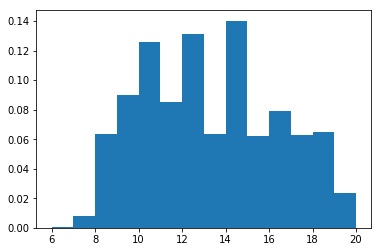

In [176]:
import matplotlib.pyplot as plt 
plt.hist(timeValid, bins=14, density=True, )